In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tqdm import tqdm

2022-07-29 14:39:32.439778: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
dataset = tfds.load("mnist", split="train")
train_data = dataset.map(lambda data:tf.cast(data["image"], tf.float32)/255.).batch(1024)

2022-07-29 14:39:35.038536: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-07-29 14:39:35.105212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2022-07-29 14:39:35.105944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2022-07-29 14:39:35.105969: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-07-29 14:39:35.107847: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-07

In [3]:
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(512, activation="relu"),
                    tf.keras.layers.Dense(256, activation="relu"),
                    tf.keras.layers.Dense(latent_dim*2)
                ])
    
    def call(self, x):
        mu, logvar = tf.split(self.encoder(x), 2, axis=1)
        
        return mu, logvar

In [4]:
class Decoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.decoder = tf.keras.Sequential([
                    tf.keras.layers.Dense(256, activation="relu"),
                    tf.keras.layers.Dense(512, activation="relu"),
                    tf.keras.layers.Dense(784, activation="sigmoid"),
                    tf.keras.layers.Reshape((28, 28, 1))
                ])

    def call(self, z):
        return self.decoder(z)

In [5]:
n_epochs = 50
latent_dim = 2
learning_rate = 1e-3
log_interval = 10

In [6]:
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [7]:
def sample(mu, logvar):
    sample_ = tf.random.normal(mu.shape)  ## z~N(0, 1) --> z~(mu, var)  ~  mu + sigma*z
    sigma = tf.exp(0.5*logvar)  ## exp(0.5 log sigma^(2)) --> sigma
    return mu + sample_ + sigma

In [8]:
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        mu, logvar = encoder(inputs)
        z = sample(mu, logvar)
        x_recon = decoder(z)
        reconstruction_error = tf.reduce_sum(tf.losses.binary_crossentropy(inputs, x_recon))
        kl = 0.5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mu) - 1. - logvar)
        loss = (kl + reconstruction_error) / inputs.shape[0]
    
    vars_ = encoder.trainable_variables + decoder.trainable_variables
    grads_ = tape.gradient(loss, vars_)
    optimizer.apply_gradients(zip(grads_, vars_))
    
    return loss, reconstruction_error, kl

In [9]:
for epoch in range(1, n_epochs+1):
    total_loss, total_recon, total_KL = 0, 0, 0
    for x in train_data:
        loss, recon, kl = train_step(x)
        total_loss += loss * x.shape[0]
        total_recon += recon
        total_KL += kl
        
    if epoch % log_interval == 0:
        print(f"{epoch:3d} iteration : ELBO {total_loss / len(dataset):.2f}, " \
              f"Recon {total_recon / len(dataset):.2f}, " \
              f"KL {total_KL / len(dataset):.2f} ")

 10 iteration : ELBO 171.63, Recon 163.48, KL 8.15 
 20 iteration : ELBO 169.10, Recon 159.62, KL 9.48 
 30 iteration : ELBO 168.04, Recon 158.06, KL 9.97 
 40 iteration : ELBO 167.58, Recon 157.27, KL 10.31 
 50 iteration : ELBO 167.20, Recon 156.67, KL 10.53 


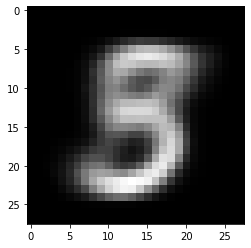

In [14]:
mu = tf.zeros((1, latent_dim))
logvar = tf.zeros((1, latent_dim))

z = sample(mu, logvar)
x = decoder(z)
plt.imshow(x[0, :, :, 0], cmap='gray')